**Importing Essential Libraries**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!mkdir '/content/drive/MyDrive/Neural NetWork dataset/wk48+'

In [4]:
#!unzip '/content/drive/MyDrive/Neural NetWork dataset/ck+48.zip' -d '/content/drive/MyDrive/Neural NetWork dataset/wk48+'

In [3]:
#specify the path to the train/test folders
DATADIR = '/content/drive/MyDrive/Neural NetWork dataset/wk48+/CK+48'




In [4]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [5]:
def load_data():
    DATADIR = '/content/drive/MyDrive/Neural NetWork dataset/wk48+/CK+48'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [6]:
data = load_data()

100%|██████████| 249/249 [00:02<00:00, 122.77it/s]


In [7]:
len(data)

981

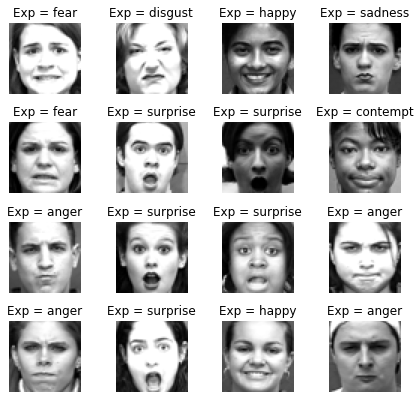

In [8]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (7,7))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Exp = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [9]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [11]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [12]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [13]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

In [14]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train[0]

array([6])

In [16]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

y_train.shape, y_test.shape

((784, 7), (197, 7))

----
**Cnn with Hog**
---

In [17]:
from skimage.transform import resize
from skimage.feature import hog

In [18]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [19]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

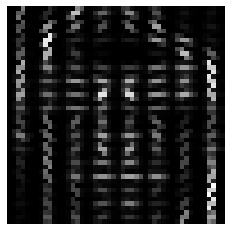

In [20]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [21]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

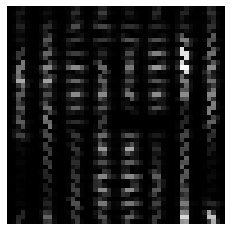

In [22]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [23]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [24]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


In [25]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [26]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [27]:
HOG_model = create_model()

In [28]:
HOG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

In [29]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [30]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=50, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 5s 38ms/step - loss: 1.8522 - accuracy: 0.2449 - val_loss: 1.8247 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 3s 30ms/step - loss: 1.8200 - accuracy: 0.2474 - val_loss: 1.7746 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 3s 30ms/step - loss: 1.7614 - accuracy: 0.2742 - val_loss: 1.7323 - val_accuracy: 0.2335 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 3s 29ms/step - loss: 1.6719 - accuracy: 0.3495 - val_loss: 1.5708 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 3s 30ms/step - loss: 1.4187 - accuracy: 0.4885 - val_loss: 1.1581 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 29ms/step - loss: 1.1119 - accuracy: 0.6020 - val_loss: 0.9451 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 3s 30ms/step - loss: 0.9

In [31]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

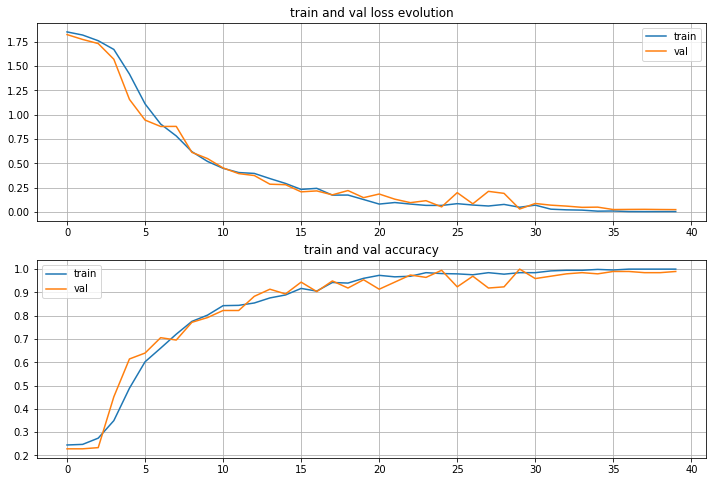

In [32]:
plot_performance(HOG_history)

In [33]:
acc = []

In [34]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 1.0


In [35]:
HOG_model.save('/content/drive/MyDrive/Neural NetWork dataset/HOG_model.h5')

In [36]:
new_Hog_model = tf.keras.models.load_model('/content/drive/MyDrive/Neural NetWork dataset/HOG_model.h5')

----
**CNN**
---
----

In [37]:
normal_model  = create_model()

In [38]:
normal_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 64)        

In [39]:
normal_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [40]:
normal_model_history = normal_model.fit(X_train, y_train, batch_size=8 , epochs=50, validation_data = (X_test, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 4s 32ms/step - loss: 1.8585 - accuracy: 0.2283 - val_loss: 1.8110 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 3s 29ms/step - loss: 1.8378 - accuracy: 0.2704 - val_loss: 1.8069 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 3s 30ms/step - loss: 1.8290 - accuracy: 0.2640 - val_loss: 1.8085 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 3s 30ms/step - loss: 1.3868 - accuracy: 0.4987 - val_loss: 0.9767 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 3s 29ms/step - loss: 0.9346 - accuracy: 0.6543 - val_loss: 0.7797 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 30ms/step - loss: 0.6988 - accuracy: 0.7283 - val_loss: 0.7319 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 4s 37ms/step - loss: 0.6

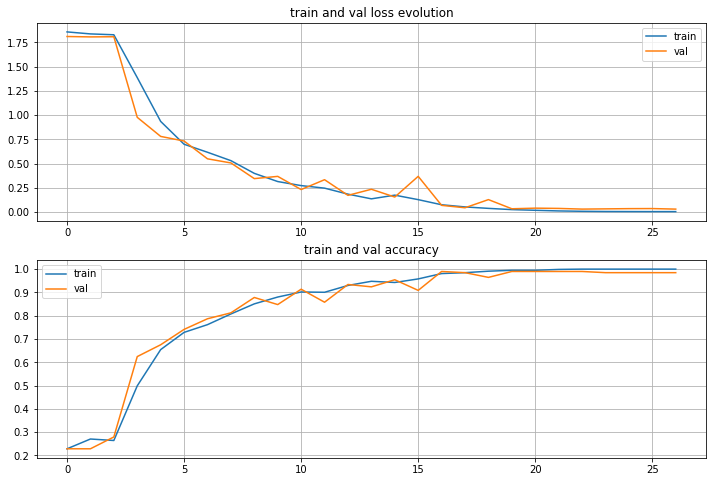

In [41]:
plot_performance(normal_model_history)

In [42]:
normal_model.save('/content/drive/MyDrive/Neural NetWork dataset/normal_model.h5')

In [43]:
new_normal_model = tf.keras.models.load_model('/content/drive/MyDrive/Neural NetWork dataset/normal_model.h5')

----
**Predict**
---
----

In [44]:
import cv2
#frame = cv2.imread('/content/happyman2.jpg')
frame = cv2.imread('/content/supprisedman.jpg')

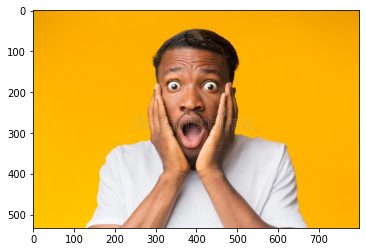

In [45]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

**Resimi Haar Cascade için hazırla**

In [46]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [47]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray.shape

(533, 800)

In [48]:
faces = faceCascade.detectMultiScale(gray,1.1,4)

for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2) #BGR
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
      print("Face not detected")    
    else: 
      for (ex,ey,ew,eh) in facess:
        face_roi = roi_color[ey : ey+eh, ex: ex+ew] 

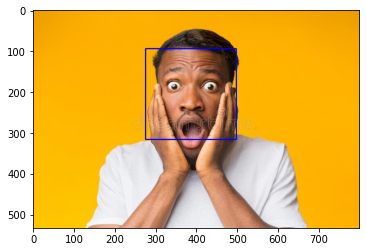

In [49]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

**Cropped detected face from image**

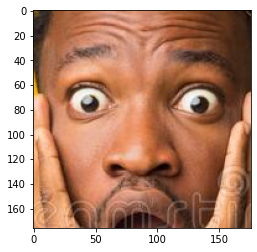

In [50]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))


**Cropped face with Original image and Hog image**

(-0.5, 47.5, 47.5, -0.5)

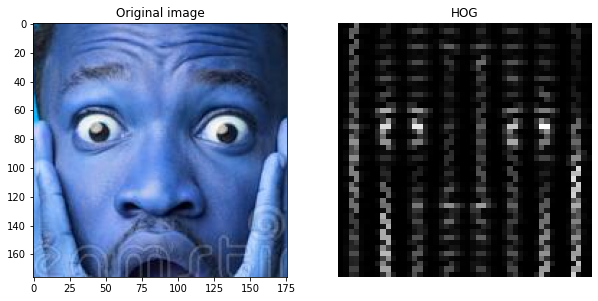

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
img = face_roi
# first image needs to be resized before passing it to HOG descriptor
resized_img =  resize(img, (128, 64))
plt.title("Original image")
plt.imshow(img, cmap='gray')
fd, hog_image = hog(
    resized_img, 
    orientations=9, 
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), 
    visualize=True, 
    multichannel=True
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')

In [52]:
print(hog_image.shape)
print(face_roi.shape)

(128, 64)
(176, 176, 3)


**Hog ve normal resimimizi predict için hazırlamak**

In [53]:
print("Original Image :" , face_roi.shape)
gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
print("after gray: ",gray.shape)
final_image = cv2.resize(gray,(48,48))

final_image_face_roi = np.expand_dims(final_image,axis=0)
print(final_image_face_roi.shape) #final image was face roi

print("-----")
print("Hog_image :" , hog_image.shape)
#gray = cv2.cvtColor(hog_image, cv2.COLOR_BGR2GRAY)
print("after gray: ",gray.shape)
final_image = cv2.resize(gray,(48,48))

final_image_hog_image = np.expand_dims(final_image,axis=0)
final_image_hog_image.shape #final image was face roi


Original Image : (176, 176, 3)
after gray:  (176, 176)
(1, 48, 48)
-----
Hog_image : (128, 64)
after gray:  (176, 176)


(1, 48, 48)

In [54]:
def emotion(i):
      switcher={
                0:'Angry',
                1:'Disgust',
                2:'Fear',
                3:'Happy',
                4:'Neutral',
                5:'Sad',
                6:'Suprise'
             }
      return switcher.get(i,"No emotion, Error!")

**Predict**



In [55]:
Prediction_Hog = HOG_model.predict(final_image_hog_image)
Prediction_Normal = normal_model.predict(final_image_face_roi)

In [56]:
print(Prediction_Hog[0])
print(Prediction_Normal[0])

[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


In [57]:
print("Hog image = ",emotion(np.argmax(Prediction_Hog)))

Hog image =  Happy


In [58]:
print("Normal image = ",emotion(np.argmax(Prediction_Normal)))

Normal image =  Suprise


-----
**Fer2013**
---
-----

**Importing Essential Libraries**

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
#!mkdir '/content/drive/MyDrive/Neural NetWork dataset/Fer2013'
!mkdir fer2013

In [ ]:
#!unzip '/content/drive/MyDrive/Neural NetWork dataset/archive.zip' -d '/content/drive/MyDrive/Neural NetWork dataset/Fer2013'
!unzip '/content/drive/MyDrive/Neural NetWork dataset/archive.zip' -d '/content/fer2013'


**Preparing dataset**

In [65]:
#specify the path to the train/test folders
#train_dir = '/content/drive/MyDrive/Neural NetWork dataset/Fer2013/train'
#val_dir = '/content/drive/MyDrive/Neural NetWork dataset/Fer2013/test'

train_dir = '/content/fer2013/train'
val_dir = '/content/fer2013/test'
#set image pixels to value of 1 or 0
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

#set image size/color/class for training and validation
train_generator = train_datagen.flow_from_directory(
        train_dir,
        #images in FER-2013 dataset are grayscale and 48x48
        target_size=(48,48),
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [66]:
import matplotlib.pyplot as plt
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

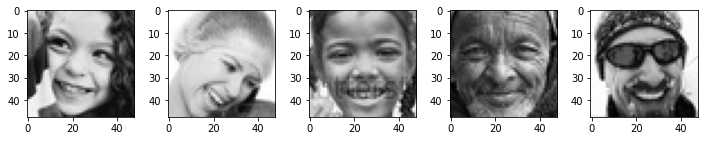

In [67]:
plot_images(train_dir+'/happy')

----
**Sequential CNN Model Building**



In [68]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

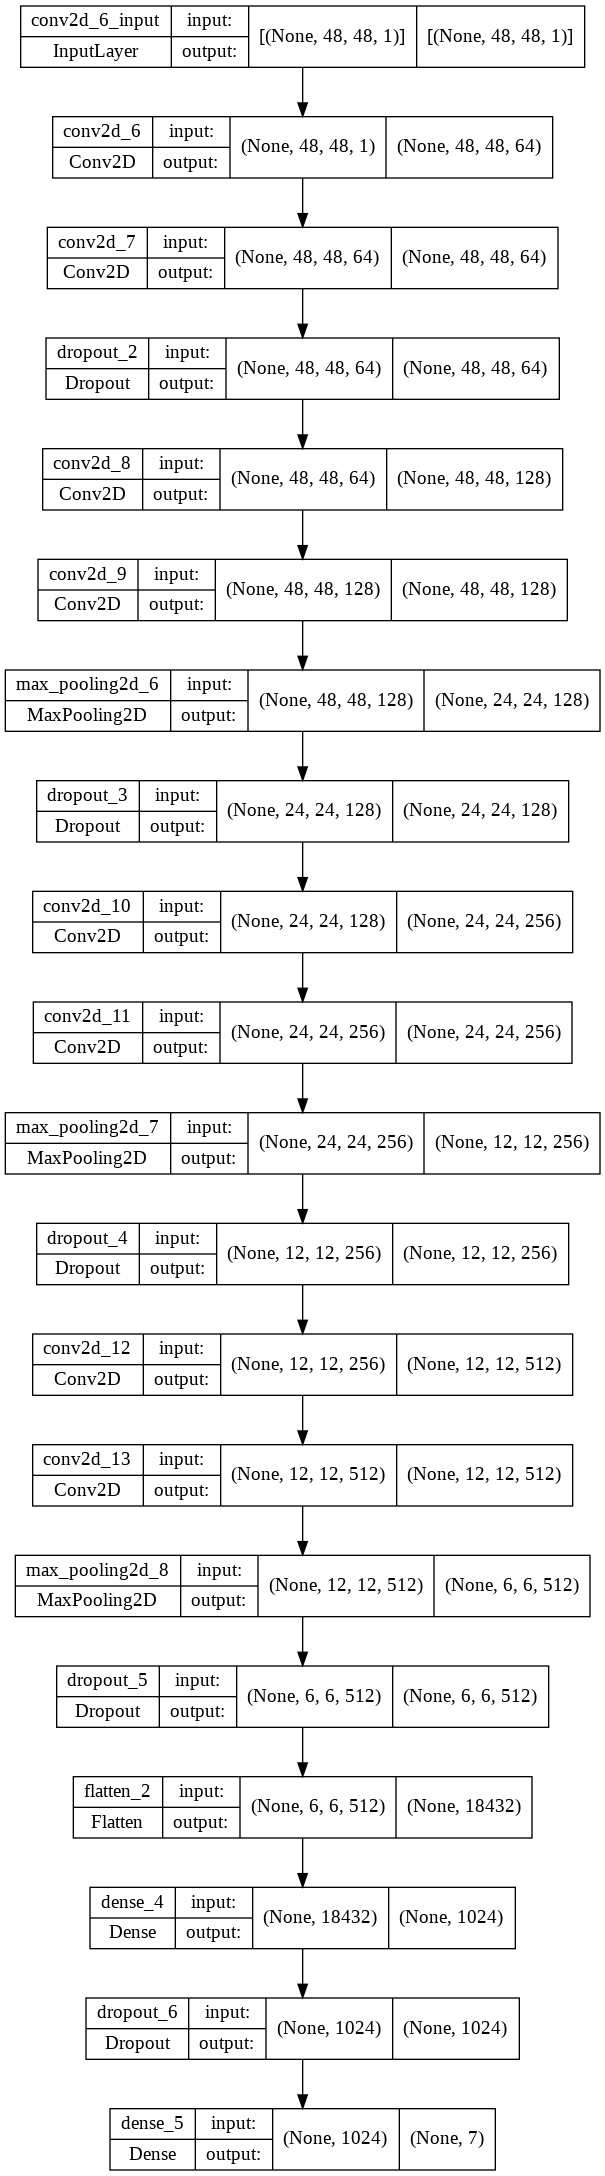

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [70]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 9.2 MB/s 
     |████████████████████████████████| 381 kB 61.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [71]:
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

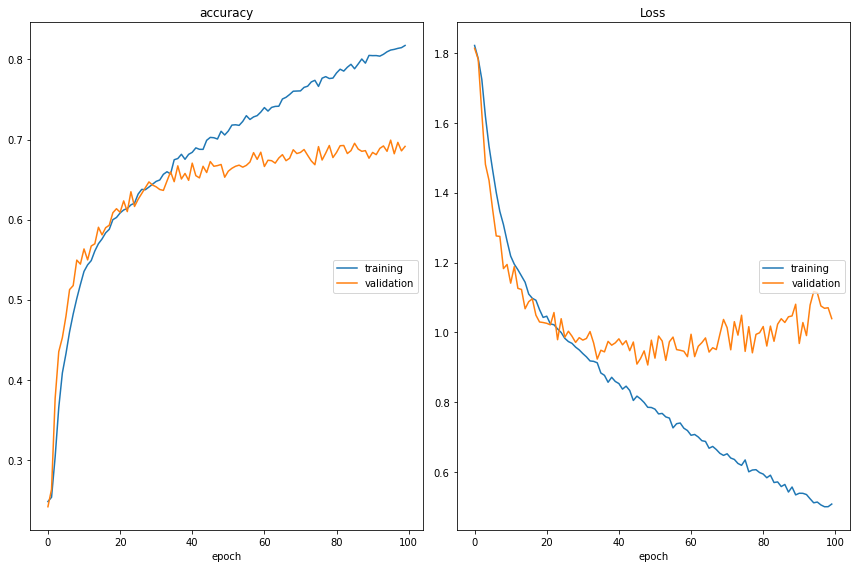

accuracy
	training         	 (min:    0.248, max:    0.817, cur:    0.817)
	validation       	 (min:    0.241, max:    0.699, cur:    0.691)
Loss
	training         	 (min:    0.501, max:    1.821, cur:    0.509)
	validation       	 (min:    0.907, max:    1.813, cur:    1.039)
448/448 [==============================] - 28s 62ms/step - loss: 0.5086 - accuracy: 0.8175 - val_loss: 1.0393 - val_accuracy: 0.6914


In [72]:
#train model over 50 iterations
model.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0001, decay=1e-7),metrics=['accuracy'])
model_info = model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=7178 // 64,
        callbacks=[plotlosses])

**Save and Load Model from GoogleDrive**

In [73]:
model.save('/content/drive/MyDrive/Neural NetWork dataset/Fer2013CNNModel.h5')

In [74]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Neural NetWork dataset/v6model.h5')

In [75]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                        

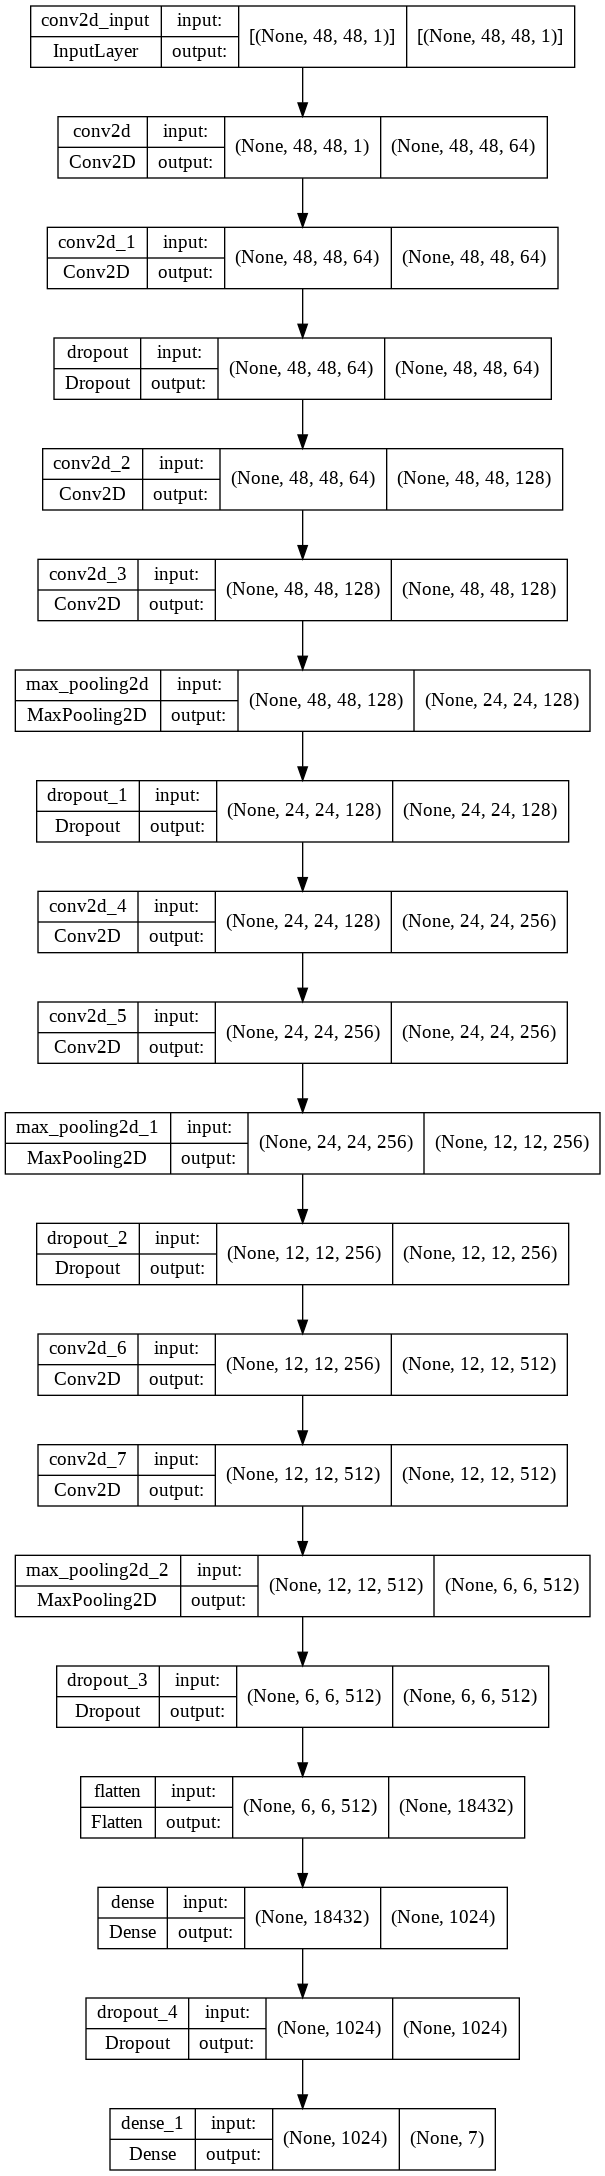

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(saved_model, to_file='fernet.png', show_shapes=True, show_layer_names=True)

**Model evaluation**


In [ ]:
train_loss, train_accu = saved_model.evaluate(train_generator)
test_loss, test_accu = saved_model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

575/898 [==================>...........] - ETA: 16s - loss: 0.3676 - accuracy: 0.8712

----
**Performance**
---
----

**Confusion Matrix and Classification on training set**

Confusion Matrix
[[ 550   62  574 1003  701  662  443]
 [  62   16   60  112   69   72   45]
 [ 527   48  593 1079  713  697  440]
 [ 946  119  998 1834 1311 1203  804]
 [ 666   56  658 1327  892  823  543]
 [ 661   65  639 1245  903  775  542]
 [ 403   49  423  859  572  517  348]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.04      0.04      0.04       436
        fear       0.15      0.14      0.15      4097
       happy       0.25      0.25      0.25      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.15      0.15      0.15     28709
weighted avg       0.17      0.17      0.17     28709



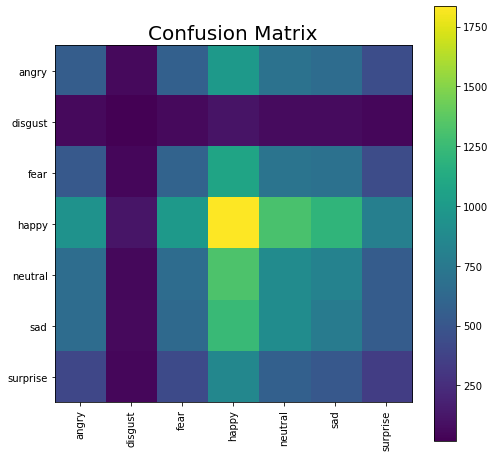

In [78]:
y_pred = saved_model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix', fontsize = 20)
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

**Confusion Matrix and Classification on test set**

Confusion Matrix
[[114  12 125 242 196 157 112]
 [ 12   1  17  31  22  17  11]
 [152  13 128 226 207 175 123]
 [216  24 233 483 323 270 225]
 [166   6 164 293 238 218 148]
 [163  22 162 317 240 214 129]
 [108   7 117 225 158 123  93]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       958
     disgust       0.01      0.01      0.01       111
        fear       0.14      0.12      0.13      1024
       happy       0.27      0.27      0.27      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



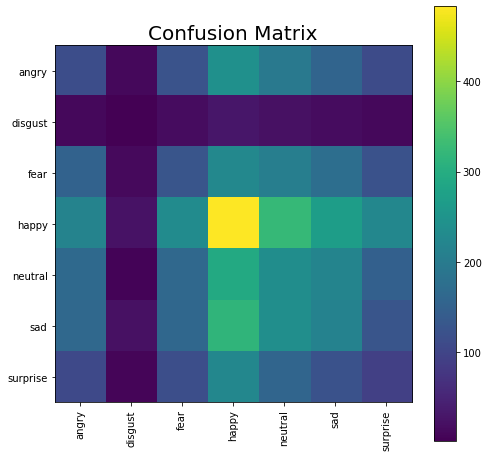

In [79]:
y_pred = saved_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix', fontsize = 20)
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

----
**Prediction**
---

-----

In [80]:
import cv2
#frame = cv2.imread('/content/happyman2.jpg')
frame = cv2.imread('/content/supprisedman.jpg')
#frame = cv2.imread('/content/angryman2.jpg')
#frame = cv2.imread('/content/tarkan2.jpg')


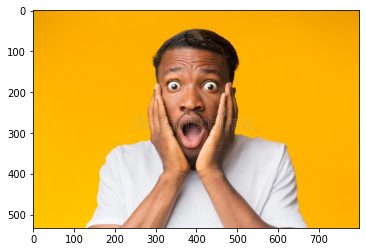

In [81]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [82]:
#we need face detection algorithm(gray image)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [83]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray.shape

(533, 800)

In [84]:
faces = faceCascade.detectMultiScale(gray,1.1,4)

for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2) #BGR
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
      print("Face not detected")    
    else: 
      for (ex,ey,ew,eh) in facess:
        face_roi = roi_color[ey : ey+eh, ex: ex+ew] 

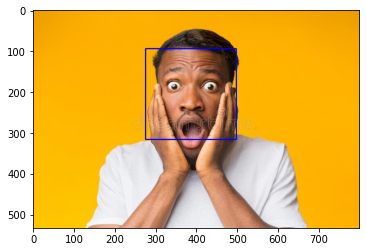

In [85]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

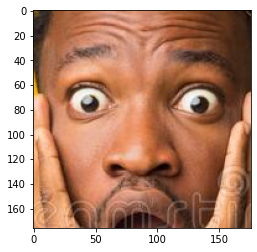

In [86]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))


In [87]:
def emotion(i):
      switcher={
                0:'Angry',
                1:'Disgust',
                2:'Fear',
                3:'Happy',
                4:'Neutral',
                5:'Sad',
                6:'Suprise'
             }
      return switcher.get(i,"No emotion, Error!")

In [88]:
print(face_roi.shape)
gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
print("after gray: ",gray.shape)
final_image = cv2.resize(gray,(48,48))
print("final image resize: ",final_image.shape)

final_image = np.expand_dims(final_image,axis=0)
final_image.shape

#X = np.array(final_image).reshape(-1,48,48,1)
#X.shape

(176, 176, 3)
after gray:  (176, 176)
final image resize:  (48, 48)


(1, 48, 48)

In [89]:
Prediction_Fer2013 = saved_model.predict(final_image)


In [90]:
Prediction_Fer2013[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [92]:
emotion(np.argmax(Prediction_Fer2013))

'Fear'